In [1]:
import pandas as pd
import numpy as np

In [2]:
import os

In [1]:
from dask_jobqueue import SLURMCluster
import dask.dataframe as dd
from dask.distributed import Client

In [4]:
data_dir = "/home/oagba/bulk/data/output_basic_15k/symptoms/csv"
data_dir = "/home/oagba/bulk/data/output_basic_45k/symptoms/csv"

In [2]:
cluster = SLURMCluster(
    queue='general',
    # project='medvice_parse',
    cores=16,
    memory='80 GB',
    walltime='00:20:00'
)

In [3]:
client = Client(cluster)
cluster.scale(1)

In [7]:
symptoms_file = os.path.join(data_dir, "symptoms.csv")

In [8]:
df = dd.read_csv(symptoms_file)

/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [9]:
df = df.loc[df.NUM_SYMPTOMS > 0]

In [10]:
df = client.persist(df)

In [11]:
mean_num_symptoms = df.NUM_SYMPTOMS.mean()

In [12]:
std_num_symptoms = df.NUM_SYMPTOMS.std()
min_num_symptoms = df.NUM_SYMPTOMS.min()
max_num_symptoms = df.NUM_SYMPTOMS.max()

In [13]:
mean, std, min_num, max_num = dd.compute(mean_num_symptoms, std_num_symptoms, min_num_symptoms, max_num_symptoms)

In [14]:
symptom_dist = [df.NUM_SYMPTOMS[df.NUM_SYMPTOMS == idx].count() for idx in range(min_num, max_num + 1)]

In [15]:
symptom_dist = dd.compute(symptom_dist)

In [16]:
symptom_dist = symptom_dist[0]

In [17]:
import matplotlib.pyplot as plt

In [18]:
fig_dir = "/shares/bulk/oagba/thesis-notebooks/zz_qce_server/figures/explore_symptom_dist_45k"
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

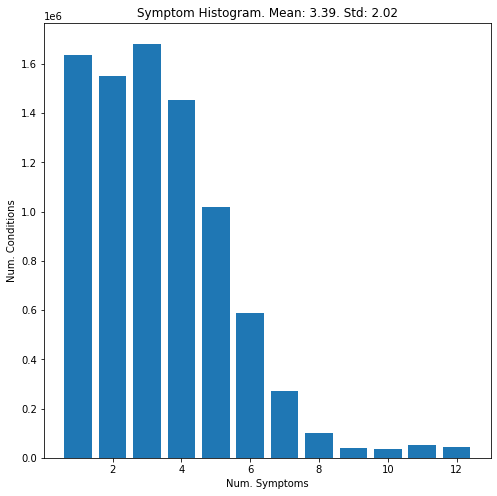

In [20]:
fig, axes = plt.subplots()
axes.set_ylabel("Num. Conditions")
axes.set_xlabel("Num. Symptoms")
axes.set_title("Symptom Histogram. Mean: %.2f. Std: %.2f" % (mean, std))
axes.bar(range(min_num, max_num +1), symptom_dist)

fig.set_size_inches(8, 8)
figname = os.path.join(fig_dir, "symptom_hist_min_1.pdf")
fig.savefig(figname)

In [21]:
# quantify data imbalance
condition_counts = df.groupby("PATHOLOGY").size().compute()

In [22]:
top_10_frequent = condition_counts.nlargest(10)

In [23]:
least_10_frequent = condition_counts.nsmallest(10)

In [24]:
average_count = condition_counts.mean()

In [25]:
std_count = condition_counts.std()

In [26]:
import json

In [27]:
condition_db = "/shares/bulk/oagba/data/definitions/condition_db.json"
with open(condition_db) as fp:
    condition_db = json.load(fp)

In [28]:
top_10_names = {item: {"name": condition_db[item], "count": int(top_10_frequent[item])} for item in top_10_frequent.index}
least_10_names = {item: {"name": condition_db[item], "count": int(least_10_frequent[item])} for item in least_10_frequent.index}

In [29]:
top_10_least_10_file = os.path.join(fig_dir, "top_10_least_10_min_symp_1_1.json")
with open(top_10_least_10_file, "w") as fp:
    json.dump({"top_10": top_10_names, "least_10": least_10_names}, fp, indent=4)

In [30]:
data = np.hstack((top_10_frequent.values, np.array([condition_counts.median()]), least_10_frequent.values[::-1]))

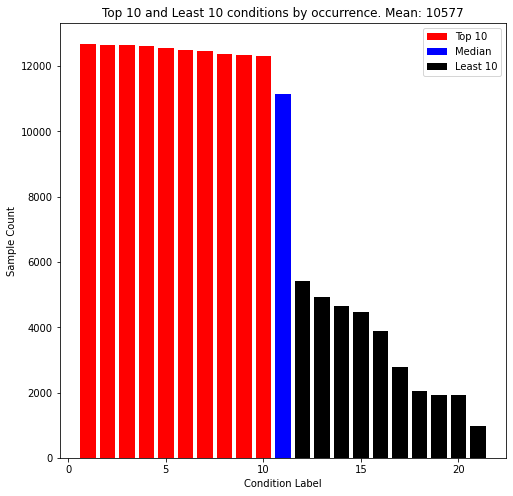

In [31]:
# we can't plot all 801 conditions, but we can plot the top and bottom two to give an idea of the range 
fig, axes = plt.subplots()
axes.set_xlabel("Condition Label")
axes.set_ylabel("Sample Count")
axes.set_title("Top 10 and Least 10 conditions by occurrence. Mean: %.0f" % average_count)

colors = ['r'] * 10 + ['b'] + ['k'] * 10
axes.bar(range(1, 11), data[:10], color='r', label='Top 10')
axes.bar(range(11, 12), data[10], color='b', label='Median')
axes.bar(range(12, len(data) + 1), data[11:], color='k', label='Least 10')
axes.legend()

fig.set_size_inches(8, 8)
figname = os.path.join(fig_dir, "top_10_least_10_median_min_1_1.pdf")
fig.savefig(figname)

In [32]:
sorted_conditions = condition_counts.nlargest(condition_counts.shape[0])

In [33]:
conditions_mean = sorted_conditions.mean()
conditions_std = sorted_conditions.std()
conditions_median = sorted_conditions.median()

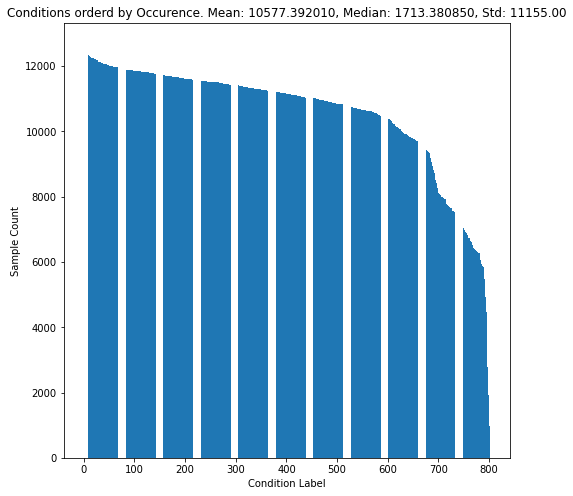

In [34]:
fig, axes = plt.subplots()
axes.bar(range(1, sorted_conditions.shape[0] + 1), sorted_conditions.values)
axes.set_xlabel("Condition Label")
axes.set_ylabel("Sample Count")
axes.set_title("Conditions orderd by Occurence. Mean: %0f, Median: %0f, Std: %.2f" % (conditions_mean, conditions_std, conditions_median))
fig.set_size_inches(8, 8)
figname = os.path.join(fig_dir, "condition_distribution_min_1_1.pdf")
fig.savefig(figname)

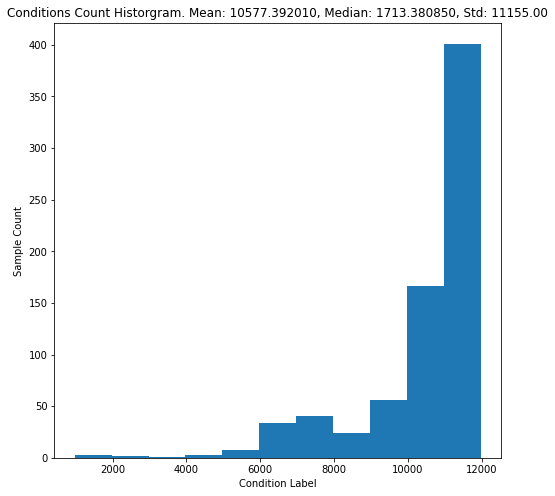

In [39]:
fig, axes = plt.subplots()
bins = range(condition_counts.min(), condition_counts.max(), 1000)
axes.hist(sorted_conditions.values, bins)
axes.set_xlabel("Condition Label")
axes.set_ylabel("Sample Count")
axes.set_title("Conditions Count Historgram. Mean: %0f, Median: %0f, Std: %.2f" % (conditions_mean, conditions_std, conditions_median))
fig.set_size_inches(8, 8)
figname = os.path.join(fig_dir, "condition_histogram_min_1_1.pdf")
fig.savefig(figname)

In [42]:
condition_counts.loc[condition_counts < 10557].size

223

In [4]:
df1 = dd.read_csv("/shares/bulk/oagba/data/output_adv_avg_cnt_15k/symptoms/csv/symptoms.csv")

/shares/bulk/oagba/work/medvice-parser/lib64/python3.6/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [5]:
shape = df1.size

In [6]:
shape = shape.compute()

In [7]:
shape

56626227